# HW 4
In this homework, we will use the Car price dataset like last week

### Data Preparation

In [302]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [303]:
selected_cols =[
                'Make',
                'Model',
                'Year',
                'Engine HP',
                'Engine Cylinders',
                'Transmission Type',
                'Vehicle Style',
                'highway MPG',
                'city mpg',
                'MSRP'
                ]

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [304]:
df = pd.read_csv('data.csv')
df = df[selected_cols]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)

In [305]:
mean_price = df.msrp.mean()
df['above_average'] = np.where(df.msrp > mean_price, 1, 0)
df = df.drop('msrp', axis=1)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [306]:
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [307]:
def train_val_test_split(df, target, train_size, val_size, test_size, random_state):
    
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    val_portion = val_size / (train_size + val_size)
    df_train, df_val = train_test_split(df_full_train, test_size=val_portion, random_state=random_state)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]

    return df_full_train, df_train, df_test, df_val, y_train, y_val, y_test

In [308]:
df_full_train, df_train, df_test, df_val, y_train, y_val, y_test = \
    train_val_test_split(df=df, target='above_average', train_size=0.6, val_size=0.2, test_size=0.2, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [309]:
numerical_vars = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

best_auc = -1
best_variable = None


for var in numerical_vars:
    auc = roc_auc_score(y_train, df_train[var])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    print(var, "AUC", auc)
    
    if auc > best_auc:
        best_auc = auc
        best_variable = var

print("Variable with the highest AUC:", best_variable)

engine_hp AUC 0.9171031265539011
engine_cylinders AUC 0.766116490165669
highway_mpg AUC 0.6330587871772013
city_mpg AUC 0.6734244643245233
Variable with the highest AUC: engine_hp


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [310]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [311]:
dv, model = train(df_train=df_train, y_train=y_train, C=1.0)
y_pred = predict(df=df_val, dv=dv, model=model)
print(f'AUC on the validaiton dataset', round(roc_auc_score(y_val,y_pred), 3))

AUC on the validaiton dataset 0.98


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [312]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred > t)
    predict_negative = (y_pred <= t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [313]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

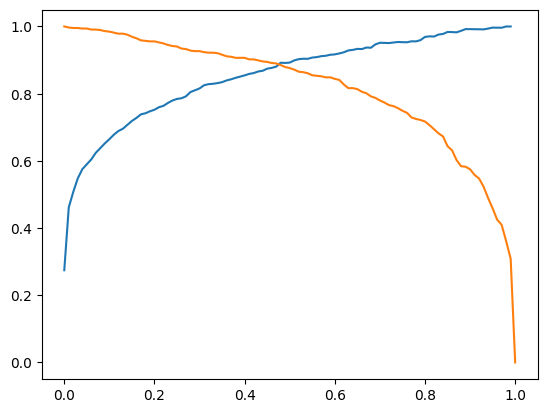

In [314]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')

In [315]:
df_scores['diff'] = abs(df_scores.precision - df_scores.recall)
df_scores[df_scores['diff'] == df_scores['diff'].min()]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,diff
48,0.48,579,70,75,1659,0.885321,0.040486,0.892142,0.885321,0.006821


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72


In [316]:
df_scores['f1_score'] = 2 * df_scores['precision'] * df_scores['recall'] / \
                        (df_scores['precision'] + df_scores['recall'])

In [317]:
max_f1 = 0
max_threshold = 0
for threshold in [0.12, 0.32, 0.52, 0.72]:
    print("Threshold=", threshold, "F1 Score",df_scores['f1_score'][df_scores.threshold == threshold].values)
    f1 = df_scores['f1_score'][df_scores.threshold == threshold].values
    if f1 > max_f1:
        max_f1 = f1
        max_threshold = threshold
print("Max F1 Score:", max_f1)
print("Threshold for Max F1 Score:", max_threshold)

Threshold= 0.12 F1 Score [0.80859128]
Threshold= 0.32 F1 Score [0.87264834]
Threshold= 0.52 F1 Score [0.88368462]
Threshold= 0.72 F1 Score [0.84843353]
Max F1 Score: [0.88368462]
Threshold for Max F1 Score: 0.52


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [318]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s Mean AUC Score %.3f +- STD %.3f' % (1.0, np.mean(scores), np.std(scores)))

C=1.0 Mean AUC Score 0.980 +- STD 0.003


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`

In [319]:
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s Mean AUC Score %.3f +- STD %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.42it/s]

C=0.01 Mean AUC Score 0.952 +- STD 0.003


 50%|█████     | 2/4 [00:01<00:01,  1.43it/s]

C=0.1 Mean AUC Score 0.972 +- STD 0.002


 75%|███████▌  | 3/4 [00:02<00:00,  1.40it/s]

C=0.5 Mean AUC Score 0.978 +- STD 0.002


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

C=10 Mean AUC Score 0.982 +- STD 0.003
